In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go


In [3]:
DEBUG = False

### Reading data

In [4]:
from datetime import datetime
df = pd.read_csv('data/train.csv')


df.total.replace("?", 0, inplace=True)
df.total = df.total.astype(int)
df.datetime = pd.to_datetime(df.datetime)
df.sort_values(by='datetime', inplace=True)
df.rename(columns={'datetime': 'ds', 'total': 'y'}, inplace=True)

df_train, df_test = df[df.ds < datetime(
    2008, 1, 1)], df[df.ds >= datetime(2008, 1, 1)]


### Analyzing data

In [5]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)


def filter_df_by_year(df, year):
    return df[df.ds.dt.year == year]


def filter_df_by_month(df, year, month):
    return df[(df.ds.dt.year == year) & (df.ds.dt.month == month)]


def filter_df_by_day(df, year, month, day):
    return df[(df.ds.dt.year == year) & (df.ds.dt.month == month) & (df.ds.dt.day == day)]


def plotly_df(data, title='', mode="marker"):
    if mode == "marker":
        fig = go.Figure()
        fig.add_trace(go.Scatter(
            x=data.ds,
            y=data.y.values,
            mode="markers",
            name="Water",
            marker={"size": 5}
        ))
    else:
        fig = px.line(data, x=data.ds, y='y', title=title, markers=True)
    fig.show()


# plotly_df(df, title="Water consumption (All)")
# plotly_df(filter_df_by_year(df, 2005), title="Water consumption (2005)")
# plotly_df(filter_df_by_year(df, 2006), title="Water consumption (2006)")
# plotly_df(filter_df_by_year(df, 2007), title="Water consumption (2007)")
# plotly_df(filter_df_by_year(df, 2008), title="Water consumption (2008)")
plotly_df(filter_df_by_month(df, 2006, 3),
          title="Water consumption (March 2006)")
plotly_df(filter_df_by_day(df, 2006, 3, 1), title="Water consumption (March 1, 2006)", mode="line")


In [6]:
INDEX = 19514
print(datetime(2005, 1, 1) + pd.Timedelta(INDEX, unit='H'))


2007-03-25 02:00:00


### Training

In [13]:
from prophet import Prophet


m = Prophet(
    changepoint_prior_scale=20,
    seasonality_prior_scale=40,
    holidays_prior_scale=20,
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=False
)

m.add_seasonality(name='weekly', period=7, fourier_order=30)
m.add_seasonality(name='daily', period=1, fourier_order=30)
m.add_seasonality(name="monthly", period=30.5, fourier_order=30)
m.add_seasonality(name="yearly", period=365.25, fourier_order=20)
m.add_seasonality(name="quarterly", period=91, fourier_order=20)
# m.add_seasonality(name="hourly", period=1/24, fourier_order=10)

m.add_country_holidays(country_name='RU')
m.fit(df=(df_train if DEBUG else df))


/home/alantheknight/nto-final/team/.venv/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -3226.89
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       81238.8   0.000646666       1740.85           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       81294.3   0.000699969       533.723           1           1      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       81301.8    0.00218234       404.308           1           1      329   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       81307.5    0.00014565       339.701           1           1      435   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       81310.1   0.000202442       254.182           1           1      544   
    Iter      log prob        ||dx||      ||grad||       alpha  

In [19]:
future = m.make_future_dataframe(periods=4344, freq='H', include_history=False)


In [20]:
forecast = m.predict(future)

/home/alantheknight/nto-final/team/.venv/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/alantheknight/nto-final/team/.venv/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



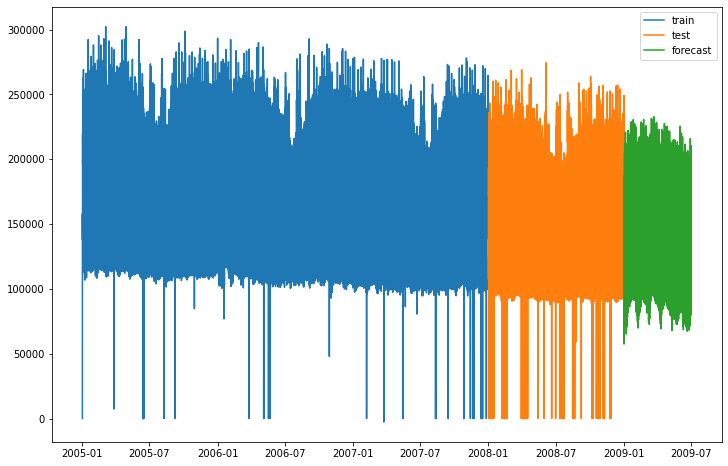

In [21]:
# Show differences between forecast and actual values
import plotly.graph_objects as go

plt.figure(figsize=(12, 8))
plt.plot(df_train.ds, df_train.y, label='train')
plt.plot(df_test.ds, df_test.y, label='test')
plt.plot(forecast.ds, forecast.yhat, label='forecast')
plt.legend()
plt.show()


In [22]:
with open("answer.txt", "w") as f:
    for v in forecast['yhat']:
        f.write(str(v))
        f.write('\n')

In [23]:
# a = m.plot_components(forecast)
# a.show()


fig = go.Figure()
fig.add_trace(go.Scatter(
    x=df_train.ds,
    y=df_train.y.values,
    mode="markers",
    name="Water",
    marker={"size": 5}
))
fig.add_trace(go.Scatter(
    x=df_test.ds,
    y=df_test.y.values,
    mode="lines",
    name="Real",
    marker={"size": 5}
))
fig.add_trace(go.Scatter(
    x=forecast.ds,
    y=forecast.yhat.values,
    mode="lines",
    name="Forecast",
    marker={"size": 5}
))

fig.show()


